In [206]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool, cpu_count
import cv2

In [207]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,                                   # paste your telegram_id
    'model_name': 'Jan_LSTM'
}

tg_callback = TelegramCallback(config)

In [208]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [209]:
train_ids = [1,2,3, 7, 8, 9, 10,12,14,15,16,17]
test_ids = [4,5,6,11,13]

In [210]:
dfAll = pd.read_pickle("PklData/df_lstm_norm50.pkl")

In [211]:
dfAll.TaskID = dfAll.TaskID % 17


In [212]:
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids)]

df_train2 = df_train[['Blobs', 'TaskID']].copy()
df_test2 = df_test[['Blobs', 'TaskID']].copy()

In [242]:
x_train = np.concatenate(df_train2.Blobs.values).reshape(-1,50,27,15,1)
x_test = np.concatenate(df_test2.Blobs.values).reshape(-1,50,27,15,1)

y_train = df_train2.TaskID.values
y_test = df_test2.TaskID.values

x_train = x_train / 255.0
x_test = x_test / 255.0

In [243]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(dfAll.TaskID.unique())
y_train_one_hot = utils.to_categorical(df_train2.TaskID, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.TaskID, num_classes)

In [250]:
import cv2
def detect_blobs(Blobs, TaskID):
    image = Blobs
    
    #image = image.reshape(27, 15)
    temp, thresh = cv2.threshold(cv2.bitwise_not(image), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 8 and cv2.contourArea(a) < 255]
    if len(contours) > 0:
        if (TaskID not in [1, 6, 7]):
            # only one blob
            contours.sort(key=lambda a: cv2.contourArea(a))
            max_contour = contours[-1]
            
            for (x, y) in max_contour.reshape(-1,2):
                plt.plot(x, y, "o", color="r")
            plt.imshow(Blobs)
            
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            
            return 15-xmax, 27-ymax, xmin, ymin
        else:
            # two blobs
            blobs = []
            contours.sort(key=lambda a: cv2.contourArea(a))
            max_contour = contours[-1]
            
            for (x, y) in max_contour.reshape(-1,2):
                plt.plot(x, y, "o", color="r")
            plt.imshow(Blobs)
                
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)

            max_contour = contours[-2]
            xmax2, ymax2 = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin2, ymin2 = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            
            return 15 - max(xmax, xmax2), 27 - max(ymax, ymax2), min(xmin, xmin2), min(ymin, ymin2)
    else:
        return 0,0,100,100

In [253]:
def getMaxOffset(Blobs, taskID):
    
    xmax = 0
    ymax = 0
    xmin = 100
    ymin = 100
    for blob in Blobs:
        blob = blob.reshape(27,15)
        blob *= 255.0
        blob = np.round(blob)
        blob = blob.astype(np.uint8)
        #print(blob.min(), blob.max())
        _xmax, _ymax, _xmin, _ymin = detect_blobs(blob, taskID)
        
        xmax = max(xmax, _xmax)
        ymax = max(ymax, _ymax)
        xmin = min(xmin, _xmin)
        ymin = min(ymin, _ymin)
    
    print(xmin, xmax, ymin, ymax)
    #BlobSum = np.sum(Blobs, keepdims=True, axis=0).reshape(27,15)
    #BlobSum *= 255.0/BlobSum.max() 
    #BlobSum = np.round(BlobSum)
    #BlobSum = BlobSum.astype(np.uint8)
    

     #np.sqrt(784) = 28
    
    #hor_sum = np.sum(BlobSum, axis=0)
    #hor_sum *= 255.0/hor_sum.max()
    #print("HOR", hor_sum)
    #hor_std = np.std(hor_sum)
    #hor_mean = np.mean(hor_sum)
    #print("STD_hor: ", hor_std, "MEAN:", hor_mean)
    #hor_thresh = hor_mean - hor_std
    #for h in range(len(hor_sum)):
    #    if (hor_sum[h] > hor_thresh):
    #        print("hor_front_thresh: ", h)
    #        break
    #for h2 in range(len(hor_sum)):
    #    if (hor_sum[-h2] > hor_thresh):
    #        print("hor_back_thresh: ", h2)
    #        break
    #ver_sum = np.sum(BlobSum, axis=1)
    #print("VER", ver_sum)
    #ver_std = np.std(ver_sum)
    #ver_mean = np.mean(ver_sum)
    #print("STD_ver:", ver_std, "MEAN: ", ver_mean)

7 5 12 11


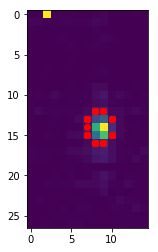

In [254]:
asdf = x_train[0].copy()
getMaxOffset(asdf, 0)


In [229]:
## Method to move one blob given from moveBlobs
## First moves in x direction, second in y direction
## Can also not move the blobs in any way if randints are 0
def moveBlob(blob, x_direction, y_direction, x_offset_left, x_offset_right, y_offset_left, y_offset_right):
    tmp = blob
    if (x_direction == 0):
        if (x_offset_left == 0): 
            tmp = np.pad(tmp,((0,0),(x_offset_left,0)), mode='constant')[:, :]
        else:
            tmp = np.pad(tmp,((0,0),(x_offset_left,0)), mode='constant')[:, :-x_offset_left]
    elif (x_direction == 1):
        if (x_offset_right == 0): 
            tmp = np.pad(tmp,((0,0),(0,x_offset_right)), mode='constant')[:, :]
        else:
            tmp = np.pad(tmp,((0,0),(0,x_offset_right)), mode='constant')[:, x_offset_right:]


    if (y_direction == 0):
        if (y_offset_left == 0): 
            tmp = np.pad(tmp,((y_offset_left,0),(0,0)), mode='constant')[:, :]
        else:
            tmp = np.pad(tmp,((y_offset_left,0),(0,0)), mode='constant')[:-y_offset_left, :]
    elif (y_direction == 1):
        if (y_offset_right == 0): 
            tmp = np.pad(tmp,((0,y_offset_right),(0,0)), mode='constant')[:, :]
        else:
            tmp = np.pad(tmp,((0,y_offset_right),(0,0)), mode='constant')[y_offset_right:, :]  
    return(tmp)

In [ ]:
## Generates randoms for x and y movement and calls moveBlobs method for each blob in Blobs
## Return numpy array of same shape as input
from random import randint
def moveBlobs(Blobs):
    print(Blobs.shape)
    x_direction = randint(0,1)
    y_direction = randint(0,1)
    
    ##Change the 2 to the min of given contour area or 4
    x_offset_left = randint(0,2)
    x_offset_right = randint(0,2)
    
    y_offset_left = randint(0,2)
    y_offset_right = randint(0,2)
    moved_blobs = []
    if (x_offset_left == 0 and x_offset_right == 0 and y_offset_left == 0 and y_offset_right == 0):
        print("No moving")
        moved_blobs = Blobs
    else:
        for i in range(len(Blobs)):
            current_blob = Blobs[i].reshape(27,15)
            moved_blob = moveBlob(current_blob, x_direction, y_direction, x_offset_left, x_offset_right, y_offset_left, y_offset_right)
            moved_blob = moved_blob.reshape(27,15,1)
            moved_blobs.append(moved_blob)
        moved_blobs = np.array(moved_blobs)
        
        
    return moved_blobs
        
        
        


In [ ]:
def myGenerator(set_name, batch_size):
    """
    This generator returns images
    """
    hdf = h5py.File(HDF5_PATH, "r")

    pSensors = hdf[set_name + "/sensors"]
    pLabels = hdf[set_name + "/labels"]

    len_train = pSensors.shape[0]
    
    randomBatchOrder = np.arange(len_train // batch_size)

    while True:
        np.random.shuffle(randomBatchOrder) 
        
        for i in range(len_train // batch_size):
            idx = randomBatchOrder[i]
            shuffled = shuffle(pSensors[idx * batch_size: (idx+1) * batch_size], pLabels[idx * batch_size: (idx+1) * batch_size])
            yield shuffled[0].reshape(-1, train_x.shape[1], train_x.shape[2]), shuffled[1].reshape(-1, train_y.shape[1])

In [ ]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [ ]:
batch_size = 40
epochs = 10000
timesteps = 50
data_dim = (27,15)
l1v = 0.005
l2v = 0.03


tf.get_default_graph()
model = Sequential()

model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', 
            padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)), input_shape=(timesteps ,27, 15, 1)))
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                                 kernel_regularizer=regularizers.l1_l2(l1v,l2v))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3), strides=None, padding='same', data_format='channels_last')))
model.add(TimeDistributed(Dropout(0.40)))

model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', 
            padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)), input_shape=(timesteps ,27, 15, 1)))
model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                                 kernel_regularizer=regularizers.l1_l2(l1v,l2v))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last')))

model.add(TimeDistributed(Flatten()))
#model.add(TimeDistributed(Dense(128)))
model.add(TimeDistributed(Dense(64)))
#model.add(TimeDistributed(Dense(32)))
model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, data_dim),kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
#model.add(Dropout(0.25))
#model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, data_dim),kernel_regularizer=regularizers.l1_l2(0.001,0.01)))
#model.add(Dense(512))
model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, data_dim),kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
#model.add(Dropout(0.20))
#model.add(Dense(256))
#model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(0.20))
#model.add(Dense(64))
model.add(Dense(num_classes, activation='softmax'))

#optimizer = optimizers.Adagrad()
optimizer = optimizers.Adam(lr = 0.0001, decay=1e-6)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Broadcast progress to the tensorboard.
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_LSTM_Jan_" + readable_timestamp

config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n" 
config += "l1: " + str(l1v) + "\n\n" + "l2: " + str(l2v) + "\n\n"

model.summary()

readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_LSTM_Jan_" + readable_timestamp
print("KnuckleFinger_LSTM_Jan_" + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_LSTM_Jan_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=100, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)

history = model.fit(x_train, y_train_one_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test_one_hot),
                        callbacks=[storer,logger,tg_callback, learning_rate_reduction])


In [ ]:
print("end")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()


In [ ]:
model.save('lstm_05_02_19_w50_b50_e1000_.l10001_l20005.h5')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    

In [ ]:

y_test_pred = model.predict(x_test, batch_size=30)
y_test_pred = np.argmax(y_test_pred, axis=1)
#model.predict(x_test)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))